In [2]:
import torch
import torch.nn as nn

from torch import optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from utils.CvTransform import CvResize, CvCenterCrop

import torch.utils.data

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import SubImgToSeq, SubVideoToSeq
from dataset.readVideo import DramaDataset
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [3]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=1,
                        timeOffset=0.2,
                        useBmp=True
                        )
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
len(datasets)

Total Drama: 113


39335

In [4]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [5]:
def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans), probs

def mutilePredit(pres, nexs, imgs):
    makes = []
    for pre, nex, img in zip(pres, nexs, imgs):
        mk = predit(model, lang, transform(img[0]).unsqueeze(0), pre)
        makes.append(mk[0])
    return makes

def toBatchFirst(outputs):
    nep = len(outputs)
    nbatch = len(outputs[0])
    bFirst = []
    for b in range(nbatch):
        bdatas = []
        for e in range(nep):
            bdatas.append(outputs[e][b])
        bFirst.append(bdatas)
    return bFirst

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
toPIL = transforms.ToPILImage()

def showImgs(imgs, preSubs, targets, labels):
    col=1
    plt.figure(figsize=(20,50))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
        plt.title("Pre: {}\nNext: {}\nPredit: {}".format(preSubs[i], targets[i], labels[i]), fontsize=20)
    plt.show()
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()
def showValue(data):
    x = range(0, len(data))
    plt.plot(x, data)
    plt.show()

In [7]:
import pickle
import os
ModelDir = "ImgSub2Sub/models/bken_fix_150"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.30.pth")).to(device).eval()

Load lang model: ImgSub2Sub/models/bken_fix_150. Word size: 15479


In [8]:
pres, nexs, imgs = getSample(5)

In [11]:
ppres, pnexs, pimgs = pres, nexs, imgs
# ppres = [ppres[0]]*len(ppres)
# pimgs = [pimgs[0]]*len(pimgs)
makes = mutilePredit(ppres, pnexs, pimgs)

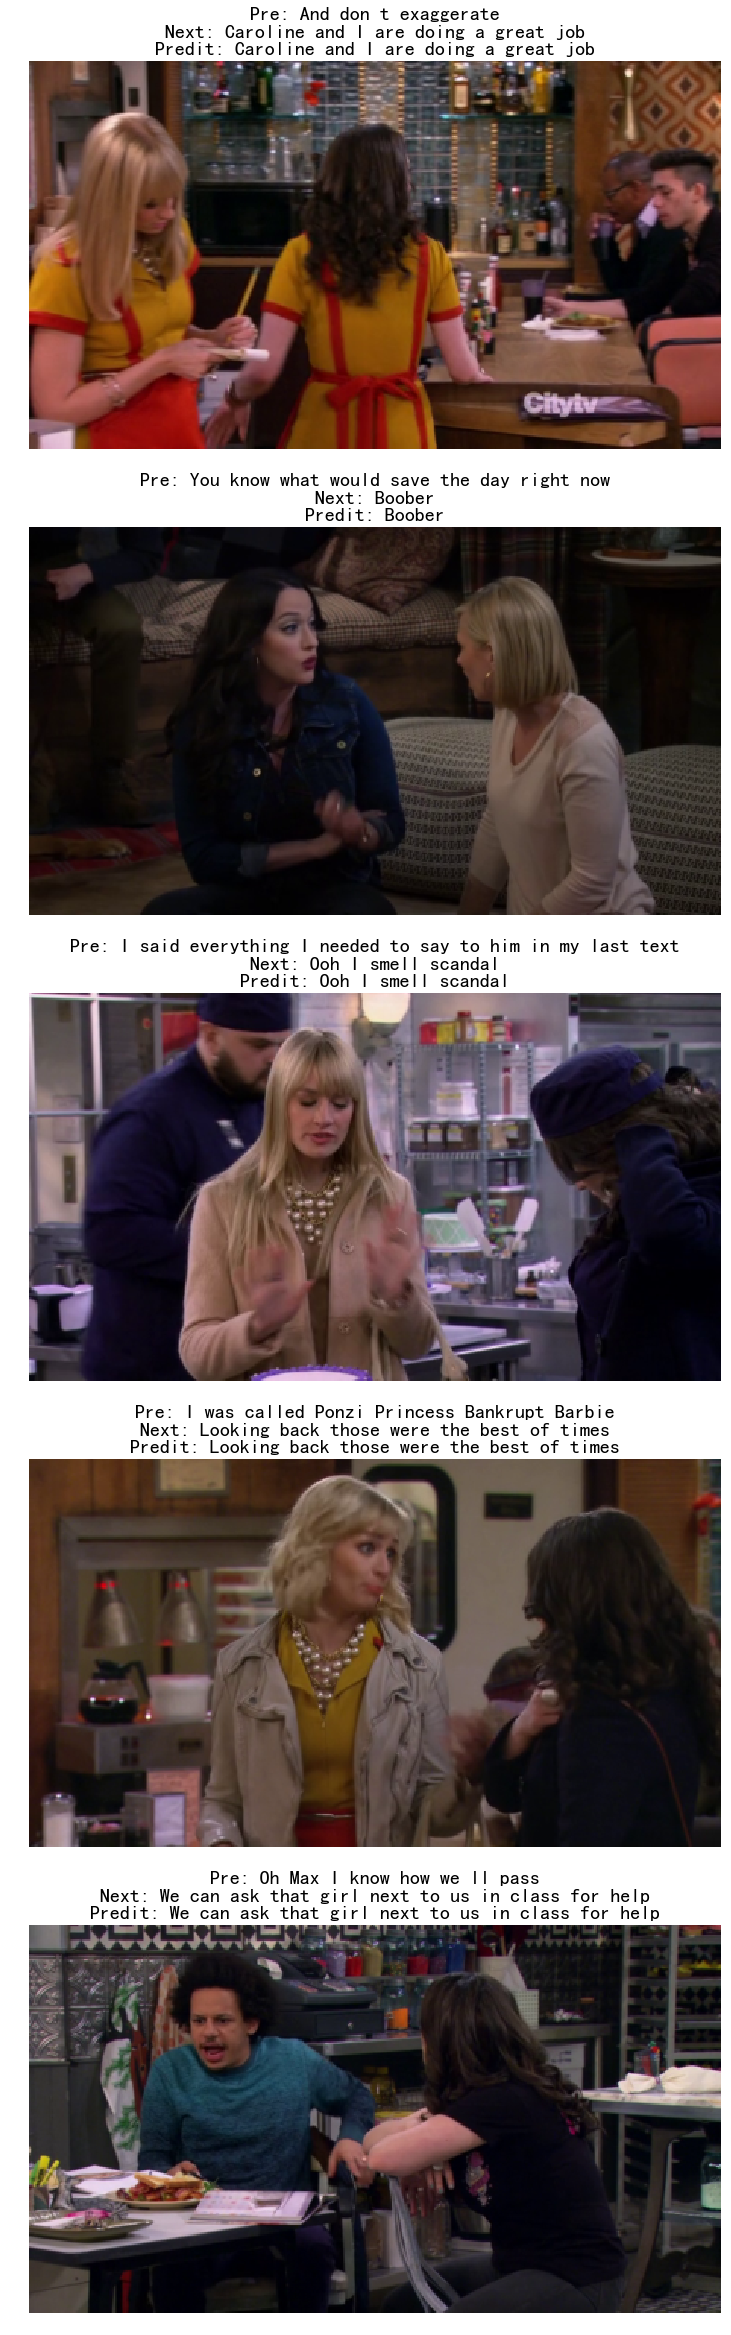

In [12]:
showImgs([ims[0] for ims in pimgs], ppres, pnexs, makes)

In [28]:
import pandas as pd
result = pd.DataFrame([], columns=["pre", "next", "make"])
for _ in range(10):
    pres, nexs, imgs = getSample(64)
    makes = mutilePredit(pres, nexs, imgs)
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    result = result.append(parts,ignore_index=True)

In [ ]:
result.to_json("result.json")

In [11]:
def getEncoder(modal, sub):
    subVar =  torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).to(device).unsqueeze(0)
    return modal.subRnn(subVar)[0][:,-1,:]
cos = nn.CosineSimilarity(dim=1)

In [20]:
pres, nexs, imgs = getSample(64)

In [40]:
epcoss = []
outputs = []
result = pd.DataFrame([], columns=["pre", "next", "make"])
for i in range(1, 31):
    model = torch.load(os.path.join(ModelDir, "SubImgModel.{}.pth".format(i))).eval()
    makes = mutilePredit(pres, nexs, imgs)
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    epcoss.append(cs.mean().item())
    outputs.append(makes)
    
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    parts["epoch"] = i
    result = result.append(parts,ignore_index=True)
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}".format(cs.mean().item(),
                                             cs.max().item(),
                                             cs.min().item()))
bfOutputs = toBatchFirst(outputs)

Mean: 0.0663, Max: 0.4489, Min: -0.3455
Mean: 0.0394, Max: 0.3669, Min: -0.2056
Mean: 0.0740, Max: 1.0000, Min: -0.2330
Mean: 0.1178, Max: 1.0000, Min: -0.1362
Mean: 0.1032, Max: 1.0000, Min: -0.2045
Mean: 0.1540, Max: 1.0000, Min: -0.1694
Mean: 0.1930, Max: 1.0000, Min: -0.1281
Mean: 0.2702, Max: 1.0000, Min: -0.1346
Mean: 0.2950, Max: 1.0000, Min: -0.1573
Mean: 0.3582, Max: 1.0000, Min: -0.1293
Mean: 0.4164, Max: 1.0000, Min: -0.1196
Mean: 0.5460, Max: 1.0000, Min: -0.0955
Mean: 0.5659, Max: 1.0000, Min: -0.1368
Mean: 0.6447, Max: 1.0000, Min: -0.1089
Mean: 0.7085, Max: 1.0000, Min: -0.0948
Mean: 0.7861, Max: 1.0000, Min: -0.0853
Mean: 0.8689, Max: 1.0000, Min: -0.0339
Mean: 0.8510, Max: 1.0000, Min: -0.1277
Mean: 0.9476, Max: 1.0000, Min: -0.0196
Mean: 0.9588, Max: 1.0000, Min: -0.0264
Mean: 0.9765, Max: 1.0000, Min: -0.0318
Mean: 0.9999, Max: 1.0000, Min: 0.9968
Mean: 1.0000, Max: 1.0000, Min: 1.0000
Mean: 0.9919, Max: 1.0000, Min: 0.4791
Mean: 0.9858, Max: 1.0000, Min: 0.0927
Mean

In [41]:
result.to_json("result.json")

In [34]:
coss = []
for makes in outputs:
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    coss.append(cs.mean().item())
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}, Equal: {}".format(cs.mean().item(),
                                                         cs.max().item(),
                                                         cs.min().item(),
                                                         (cs>=0.9).float().sum().item()))

Mean: 0.0193, Max: 0.2087, Min: -0.1917, Equal: 0.0
Mean: 0.0093, Max: 0.2711, Min: -0.1488, Equal: 0.0
Mean: 0.0536, Max: 0.8249, Min: -0.1686, Equal: 0.0
Mean: 0.0632, Max: 0.9807, Min: -0.1489, Equal: 1.0
Mean: 0.1233, Max: 1.0000, Min: -0.1408, Equal: 4.0
Mean: 0.1424, Max: 1.0000, Min: -0.1918, Equal: 6.0
Mean: 0.2442, Max: 1.0000, Min: -0.2170, Equal: 11.0
Mean: 0.3475, Max: 1.0000, Min: -0.1338, Equal: 17.0
Mean: 0.3735, Max: 1.0000, Min: -0.0920, Equal: 19.0
Mean: 0.5166, Max: 1.0000, Min: -0.1594, Equal: 28.0
Mean: 0.6435, Max: 1.0000, Min: -0.0949, Equal: 39.0
Mean: 0.6676, Max: 1.0000, Min: -0.1381, Equal: 40.0
Mean: 0.8168, Max: 1.0000, Min: -0.0567, Equal: 51.0
Mean: 0.7926, Max: 1.0000, Min: -0.0938, Equal: 49.0
Mean: 0.8888, Max: 1.0000, Min: -0.1490, Equal: 57.0
Mean: 0.9124, Max: 1.0000, Min: 0.0374, Equal: 58.0
Mean: 0.7885, Max: 1.0000, Min: -0.1352, Equal: 50.0
Mean: 0.9520, Max: 1.0000, Min: -0.0837, Equal: 61.0
Mean: 0.9702, Max: 1.0000, Min: 0.0438, Equal: 62.0
M

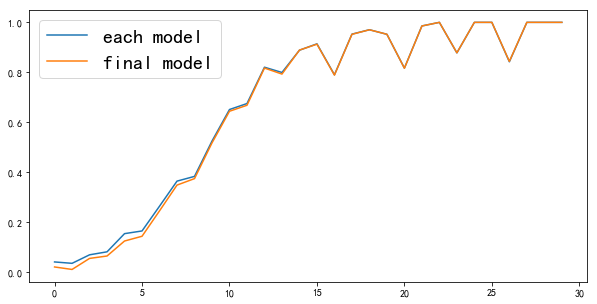

In [35]:
x = range(0, len(coss))
plt.figure(figsize=(10,5))
plt.plot(x, epcoss, label="each model")
plt.plot(x, coss, label="final model")

plt.legend(fontsize=20)
plt.show()

In [ ]:
i = 25
print("Pre: {}".format(pres[i]))
print("Next: {}\n".format(nexs[i]))
print("\n".join(bfOutputs[i]))
plt.axis('off')
plt.imshow(imgs[i][0])
plt.show()